In [97]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.optimize import curve_fit
from scipy.signal import butter, lfilter
from non_linearity.environment import Particle

In [98]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [99]:
def extract_fit_interval(freq, power, bottom_limit=6e4, upper_limit=12e4):
    freq_upper = freq[freq>bottom_limit]
    freq_fit = freq_upper[freq_upper<upper_limit]
    power_upper = power[freq>bottom_limit]
    power_fit = power_upper[freq_upper<upper_limit]
    return freq_fit, power_fit

In [100]:
def convert_gains(gain, bits_decimal = 8):
    '''
    Function to convert gain values from integer representation of multiples of 
    the ADC resolution to float
    '''
    resolution = 2**-8
    gain = -32+(gain-8192)*resolution if gain >=8192 else  gain*resolution
    return 11.27*3.03e-15*np.power(-11*1.504e4*gain,3)

In [101]:
env = Particle(2*np.pi*79e3, 13e3, radius=73e-9)

In [127]:
def lorentzian(omega,A,center,gamma,base):
    num = A*gamma
    den = (center**2-omega**2)**2+omega**2*gamma**2
    return num/den + base

def psd_exp(path_file, windows = 2, factor=1/(11*1.504e4), channel='ch1', filter_sig=True):
    data = pd.read_pickle(path_file)
    dt = data.t[1]-data.t[0]
    f = 1/dt
    freq, power = signal.welch(butter_bandpass_filter(data[channel]*factor, 1.5e2, 20e4, fs=f),
                                                      f, 
                                                      window = 'hamming', 
                                                      nperseg = int(len(data[channel])/windows))
    return freq, power


def extract_area(file, path_root, windows=20):
    freq, power = psd_exp('{}/{}'.format(path_root, file), windows=windows)
    area = power.sum()*(np.diff(freq)[0])
    return power, freq, area

    

In [128]:
intrinsice_delay = 62.5
path_root = '../data/delay/batch_0'
rp_clock = 1/(100e6)
folders = ['12374_875_0', '4010_562_0', '12374_562_0', '4010_250_0',
 '12374_1023_164', '4010_875_0', '12374_250_0', '4010_1023_164']
areas_t, areas, batches, delays, d_delay, d_gains, f_gains = [], [], [], [], [], [], []

for folder in folders:
    for file in os.listdir('{}/{}'.format(path_root, folder)):
        power, freq, area = extract_area(file, '{}/{}'.format(path_root, folder))
        areas.append(area/(env.zp_x**2))
        gain, delay1, delay2 = [int(param) for param in folder.split('_')]
        total_delay = rp_clock*(delay1+delay2)
        f_gains.append(convert_gains(gain))
        delays.append(total_delay)
        batches.append(int(file.split('.')[0]))
        d_gains.append(gain)
        d_delay.append(delay1+delay2)

In [129]:
df = pd.DataFrame()
df['gain'] = f_gains
df['digital_gain'] = d_gains
df['batch'] = batches
df['area'] = areas
df['delay'] = delays
df['digital_delay'] = d_delay

In [130]:
df.head()

,gain,digital_gain,batch,area,delay,digital_delay
0,594293.97958,12374,4,1.102934e+08,0.000009,875
1,594293.97958,12374,0,1.125939e+08,0.000009,875
2,594293.97958,12374,1,1.141950e+08,0.000009,875
3,594293.97958,12374,3,1.095268e+08,0.000009,875
4,594293.97958,12374,2,1.123750e+08,0.000009,875


In [131]:
def get_plot_params(df):
    gains = df.groupby(['digital_gain', 'digital_delay'], as_index=False)['gain'].mean()
    means = df.groupby(['digital_gain', 'digital_delay'], as_index=False)['area'].mean()
    std = df.groupby(['digital_gain', 'digital_delay'], as_index=False)['area'].std()
    return gains, means, std

In [134]:
plot_df = df.groupby(['digital_gain', 'digital_delay'], as_index=False).aggregate({'area':['mean', 'std'],
                                                                                  'gain': 'mean',
                                                                                  'delay': 'mean'})
plot_df['area_mean'] = plot_df['area']['mean']
plot_df['gain_mean'] = plot_df['gain']['mean']
plot_df['delay_mean'] = plot_df['delay']['mean']
plot_df['area_std'] = plot_df['area']['std']
plot_df = plot_df.drop('area', axis=1)
plot_df = plot_df.drop('gain', axis=1)
plot_df = plot_df.drop('delay', axis=1)
plot_df.head(30)

/var/folders/fy/4wjvjmc95f1fv0gy4d27l6_h0000gn/T/ipykernel_6607/4212476216.py:8: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  plot_df = plot_df.drop('area', axis=1)
/var/folders/fy/4wjvjmc95f1fv0gy4d27l6_h0000gn/T/ipykernel_6607/4212476216.py:9: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  plot_df = plot_df.drop('gain', axis=1)
/var/folders/fy/4wjvjmc95f1fv0gy4d27l6_h0000gn/T/ipykernel_6607/4212476216.py:10: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  plot_df = plot_df.drop('delay', axis=1)


,digital_gain,digital_delay,area_mean,gain_mean,delay_mean,area_std
,,,,,,
0,4010,250,1.373609e+08,-594293.97958,0.000003,1.815971e+06
1,4010,562,1.311206e+08,-594293.97958,0.000006,2.173114e+06
2,4010,875,1.032324e+08,-594293.97958,0.000009,1.824227e+06
3,4010,1187,1.069469e+08,-594293.97958,0.000012,1.129624e+06
4,12374,250,1.225230e+08,594293.97958,0.000003,1.555983e+06
5,12374,562,1.263065e+08,594293.97958,0.000006,1.966774e+06
6,12374,875,1.123750e+08,594293.97958,0.000009,1.879758e+06
7,12374,1187,9.357029e+07,594293.97958,0.000012,2.157644e+06


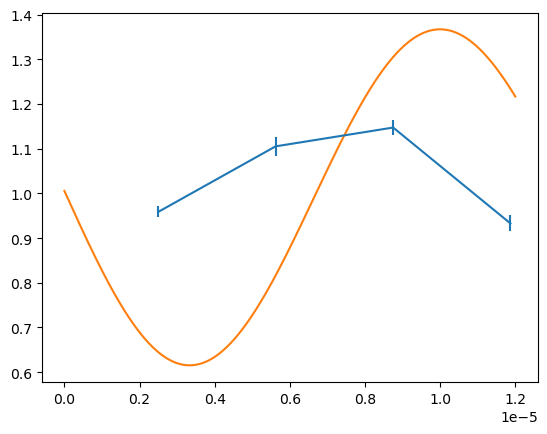

In [641]:
plot_df = plot_df.sort_values(by='delay_mean')

delays = np.linspace(0, 1.2e-5, 5000)

#plt.errorbar(gains[::5]/1e6, median_shifts[::5]/1e3, yerr=std[::5]/1e3, 
#             fmt='o', color=colors[0], markersize=4)   


plt.errorbar(plot_df[plot_df['digital_gain']==12374]['delay_mean'].values,
             plot_df[plot_df['digital_gain']==12374]['area_mean'].values,
            plot_df[plot_df['digital_gain']==12374]['area_std'].values)

#plt.plot(plot_df[plot_df['digital_gain']==8191]['delay'].values, plot_df[plot_df['digital_gain']==8191]['area_t'].values)

plt.plot(delays, theoretical_area_frac(2*np.pi*7.5e4, 13e3, -5e5/m, delays))




plt.show()

In [544]:
df.groupby(['digital_gain', 'digital_delay'], as_index=False)['gain'].mean()

/tmp/ipykernel_40656/106237882.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  df.groupby(['digital_gain', 'digital_delay'], as_index=False)['gain'].mean()


TypeError: unhashable type: 'list'

In [598]:

plot_df

digital_gain digital_delay      area                    gain     delay
                                   mean       std          mean      mean
0          4010           250  1.029529  0.013386 -5.942940e+05  0.000003
1          4010           562  1.183882  0.026633 -5.942940e+05  0.000006
2          4010           875  0.950081  0.013238 -5.942940e+05  0.000009
3          4010          1187  0.813848  0.007129 -5.942940e+05  0.000012
4          8191           250  5.506364  0.125163 -5.064995e+06  0.000003
5          8191           562  1.186847  0.018126 -5.064995e+06  0.000006
6          8191           875  0.767143  0.014026 -5.064995e+06  0.000009
7          8191          1187  0.851128  0.008024 -5.064995e+06  0.000012
8          8192           250  0.730791  0.017690  5.066850e+06  0.000003
9          8192           562  1.128742  0.017153  5.066850e+06  0.000006
10         8192           875  8.556944  0.373059  5.066850e+06  0.000009
11         8192          1187  1.369116  0.066075  5.066850e+06  0.000012
12        12374           250  0.958531  0.012430  5.942940e+05  0.000003
13        12374           562  1.105041  0.021500  5.942940e+05  0.000006
14        12374           875  1.147139  0.016820  5.942940e+05  0.000009
15        12374          1187  0.932726  0.017954  5.942940e+05  0.000012

In [450]:
root_folder = '../data/delay/batch_0'
p = []
plt.figure() 

#folders = ['0_4010_250_0', '4010_250_0']#, '4010_562_0', '0_4010_250_0']


areas = []
areas_t = []
for folder in folders:
    freq, power = psd('{}/{}'.format(root_folder, folder), factor=1/(11*1.504e4))
    area = power.sum()*np.diff(freq)[0]
    
    
    
    freq, power = psd('{}/0_{}'.format(root_folder, folder), factor=1/(11*1.504e4))
    freq_fit, power_fit = extract_fit_interval(freq, power, bottom_limit=7e4, upper_limit=9e4)
    ref_area = power.sum()*np.diff(freq)[0]
    gain, delay1, delay2 = [int(param) for param in folder.split('_')]
    areas.append(area/ref_area)



    p0 =  [3963600.1039417023, 2*np.pi*79000.0, 314284.2758744481, 0]
    ans,cov = curve_fit(lorentzian, 2*np.pi*freq_fit, power_fit, p0=p0, absolute_sigma=True, maxfev=10000)
    gamma = 13578.7501
    omega = ans[1]
    gain, delay1, delay2 = [int(param) for param in folder.split('_')]
    total_delay = rp_clock*(delay1+delay2)
    T0 = autocor_0(0, omega, gamma)
    T1 = autocor_perturbation(0, omega, gamma, -convert_gains(gain)/m, total_delay)
    areas_t.append(abs(T1)/abs(T0))
        

<Figure size 640x480 with 0 Axes>

(0.0, 8.0)

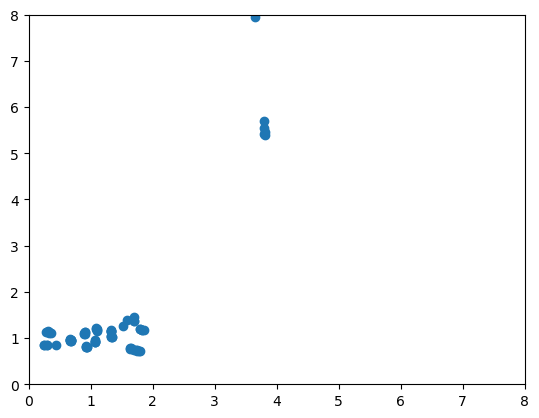

In [571]:
plt.scatter(areas_t, areas)
plt.xlim([0,8])
plt.ylim([0,8])

594293.979579706
[1.3201342106540233]
-594293.979579706
[1.3201342106540233, 1.1136942221353807]
594293.979579706
[1.3201342106540233, 1.1136942221353807, 0.9071527643573012]
-594293.979579706
[1.3201342106540233, 1.1136942221353807, 0.9071527643573012, 1.328011549505738]
594293.979579706
[1.3201342106540233, 1.1136942221353807, 0.9071527643573012, 1.328011549505738, 1.0949115916889043]
-594293.979579706
[1.3201342106540233, 1.1136942221353807, 0.9071527643573012, 1.328011549505738, 1.0949115916889043, 0.6799066129547533]
594293.979579706
[1.3201342106540233, 1.1136942221353807, 0.9071527643573012, 1.328011549505738, 1.0949115916889043, 0.6799066129547533, 0.6799387206362235]
-594293.979579706
[1.3201342106540233, 1.1136942221353807, 0.9071527643573012, 1.328011549505738, 1.0949115916889043, 0.6799066129547533, 0.6799387206362235, 0.938671491485355]


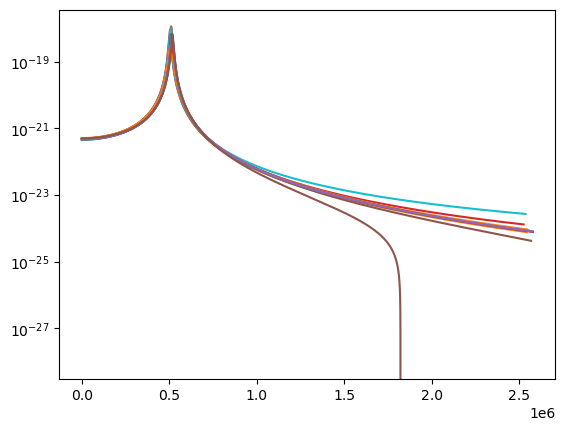

In [372]:
rp_clock = 1/(100e6)
areas_t = []
for folder in folders:
    freq, power = psd('{}/{}'.format(root_folder, folder), factor=1/(11*1.504e4))
    freq_fit, power_fit = extract_fit_interval(freq, power, bottom_limit=7e4, upper_limit=9e4)
    p0 =  [3963600.1039417023, 2*np.pi*79000.0, 314284.2758744481, 0]
    ans,cov = curve_fit(lorentzian, 2*np.pi*freq_fit, power_fit, p0=p0, absolute_sigma=True, maxfev=10000)
    
    
    gamma = 13578.7501
    omega = ans[1]
    omegas = np.linspace(0, 5*omega, int(1e5))
    delta_omega = np.diff(omegas)[0]
    gain, delay1, delay2 = [int(param) for param in folder.split('_')]
    total_delay = rp_clock*(delay1+delay2)
    if not (gain in [8191, 8192]):
        gain = convert_gains(gain)
        print(gain)
        theory_psd_s1 = S1(omegas, omega, gamma, gain, total_delay)
        theory_psd_s0 = S0(omegas, omega, gamma)
        areas_t.append(theory_psd_s1.sum()*delta_omega/(theory_psd_s0.sum()*delta_omega))
        print(areas_t)
        plt.plot(omegas, theory_psd_s0)
        plt.plot(omegas, theory_psd_s1)

plt.yscale('log')
    #plt.plot(freq_fit, power_fit)
#plt.plot(freq_fit, lorentzian(2*np.pi*freq_fit, *ans))

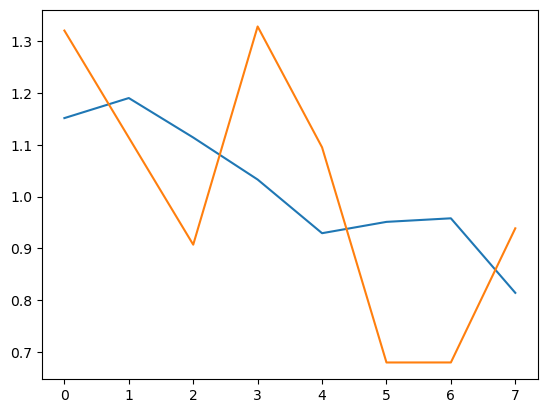

In [374]:
plt.plot(areas)
plt.plot(areas_t)